In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

iter 1: 0.138843
iter 2: 0.105866
iter 3: 0.0628633
iter 4: 0.0606301
iter 5: 0.0454088
iter 6: 0.0643969
iter 7: 0.0443717
iter 8: 0.0422394
iter 9: 0.0429941
iter 10: 0.0431529
iter 11: 0.045937
iter 12: 0.0456387
iter 13: 0.0491327
iter 14: 0.0430619
iter 15: 0.0406518
iter 16: 0.0393807
iter 17: 0.035025
iter 18: 0.0389065
iter 19: 0.0396872
iter 20: 0.0434352
iter 21: 0.0370508
iter 22: 0.0388699
iter 23: 0.0400041
iter 24: 0.0392846
iter 25: 0.0445539
iter 26: 0.0365852
iter 27: 0.0377242
iter 28: 0.0333758
iter 29: 0.0381276
iter 30: 0.0404382
iter 31: 0.035491
iter 32: 0.0335118
iter 33: 0.0358699
iter 34: 0.0366568
iter 35: 0.0355243
iter 36: 0.0353162
iter 37: 0.0420875
iter 38: 0.0334758
iter 39: 0.0341534
iter 40: 0.0433012
iter 41: 0.0343564
iter 42: 0.0275041
iter 43: 0.031448
iter 44: 0.0355387
iter 45: 0.0321629
iter 46: 0.0343928
iter 47: 0.0324702
iter 48: 0.0269105
iter 49: 0.037414
iter 50: 0.0299131
iter 51: 0.0276393
iter 52: 0.0353168
iter 53: 0.0364754
iter 54: 

iter 422: 0.0316151
iter 423: 0.0347501
iter 424: 0.032639
iter 425: 0.031559
iter 426: 0.027448
iter 427: 0.0354927
iter 428: 0.0340616
iter 429: 0.0314821
iter 430: 0.0346883
iter 431: 0.0332149
iter 432: 0.0374678
iter 433: 0.0345581
iter 434: 0.0310272
iter 435: 0.030631
iter 436: 0.0344773
iter 437: 0.0384698
iter 438: 0.0323405
iter 439: 0.0327355
iter 440: 0.0299176
iter 441: 0.0319521
iter 442: 0.0311211
iter 443: 0.0317241
iter 444: 0.0346793
iter 445: 0.033179
iter 446: 0.0289486
iter 447: 0.0345251
iter 448: 0.0351115
iter 449: 0.0290031
iter 450: 0.0326638
iter 451: 0.0274056
iter 452: 0.0348772
iter 453: 0.0330603
iter 454: 0.0299671
iter 455: 0.0339659
iter 456: 0.0257175
iter 457: 0.0392272
iter 458: 0.0376084
iter 459: 0.0347407
iter 460: 0.0300237
iter 461: 0.0304416
iter 462: 0.0322979
iter 463: 0.0297613
iter 464: 0.0344778
iter 465: 0.0325171
iter 466: 0.0305901
iter 467: 0.028999
iter 468: 0.0303313
iter 469: 0.0329748
iter 470: 0.0290735
iter 471: 0.0257132
iter 4

iter 830: 0.00390919
iter 831: 0.00637763
iter 832: 0.0065469
iter 833: 0.0046468
iter 834: 0.00426219
iter 835: 0.00469814
iter 836: 0.0057518
iter 837: 0.00366457
iter 838: 0.00447616
iter 839: 0.00409257
iter 840: 0.00775091
iter 841: 0.00461524
iter 842: 0.00717381
iter 843: 0.00651097
iter 844: 0.00552702
iter 845: 0.00550085
iter 846: 0.00742513
iter 847: 0.00709957
iter 848: 0.00591036
iter 849: 0.00536244
iter 850: 0.0074616
iter 851: 0.00648287
iter 852: 0.00649414
iter 853: 0.00441165
iter 854: 0.00553807
iter 855: 0.00588674
iter 856: 0.00469972
iter 857: 0.00605104
iter 858: 0.00507888
iter 859: 0.00488778
iter 860: 0.0043468
iter 861: 0.00400077
iter 862: 0.00446773
iter 863: 0.00551655
iter 864: 0.00540999
iter 865: 0.00454134
iter 866: 0.00480328
iter 867: 0.00567125
iter 868: 0.00508934
iter 869: 0.00476421
iter 870: 0.00451564
iter 871: 0.00461942
iter 872: 0.00610168
iter 873: 0.00359394
iter 874: 0.00469739
iter 875: 0.00392902
iter 876: 0.00549339
iter 877: 0.004388

iter 1213: 0.00353748
iter 1214: 0.00278168
iter 1215: 0.00278747
iter 1216: 0.00244376
iter 1217: 0.00286032
iter 1218: 0.00244239
iter 1219: 0.00294833
iter 1220: 0.00311748
iter 1221: 0.00228448
iter 1222: 0.00453164
iter 1223: 0.00433867
iter 1224: 0.00317555
iter 1225: 0.00363745
iter 1226: 0.00506998
iter 1227: 0.00387345
iter 1228: 0.00447011
iter 1229: 0.00344499
iter 1230: 0.00414066
iter 1231: 0.00349492
iter 1232: 0.00444961
iter 1233: 0.00363819
iter 1234: 0.00488805
iter 1235: 0.00404519
iter 1236: 0.00364451
iter 1237: 0.00361647
iter 1238: 0.00321884
iter 1239: 0.00333876
iter 1240: 0.00493816
iter 1241: 0.00381621
iter 1242: 0.00490897
iter 1243: 0.0033798
iter 1244: 0.00385718
iter 1245: 0.00371027
iter 1246: 0.00323017
iter 1247: 0.00344008
iter 1248: 0.0041527
iter 1249: 0.00337957
iter 1250: 0.0040155
iter 1251: 0.00324371
iter 1252: 0.0045818
iter 1253: 0.0037946
iter 1254: 0.00451095
iter 1255: 0.00260147
iter 1256: 0.00416392
iter 1257: 0.00359572
iter 1258: 0.00

iter 1591: 0.00212902
iter 1592: 0.0020125
iter 1593: 0.00242521
iter 1594: 0.00363937
iter 1595: 0.00247269
iter 1596: 0.00225209
iter 1597: 0.00243033
iter 1598: 0.00265021
iter 1599: 0.00212023
iter 1600: 0.00238575
iter 1601: 0.00228817
iter 1602: 0.00184978
iter 1603: 0.00172786
iter 1604: 0.00169165
iter 1605: 0.00203133
iter 1606: 0.00188981
iter 1607: 0.00156506
iter 1608: 0.00183617
iter 1609: 0.00243046
iter 1610: 0.00177589
iter 1611: 0.00215168
iter 1612: 0.00222702
iter 1613: 0.00211074
iter 1614: 0.00193512
iter 1615: 0.00199436
iter 1616: 0.00208247
iter 1617: 0.0021351
iter 1618: 0.0016862
iter 1619: 0.0028078
iter 1620: 0.00156673
iter 1621: 0.00209354
iter 1622: 0.00214924
iter 1623: 0.00251055
iter 1624: 0.00231223
iter 1625: 0.00146627
iter 1626: 0.00173081
iter 1627: 0.00267483
iter 1628: 0.00214858
iter 1629: 0.00246279
iter 1630: 0.00296905
iter 1631: 0.00155184
iter 1632: 0.0020362
iter 1633: 0.00197253
iter 1634: 0.00201772
iter 1635: 0.00217038
iter 1636: 0.00

iter 1966: 0.00151362
iter 1967: 0.00184766
iter 1968: 0.0010955
iter 1969: 0.00153139
iter 1970: 0.00183228
iter 1971: 0.00140245
iter 1972: 0.0016029
iter 1973: 0.00105388
iter 1974: 0.00132897
iter 1975: 0.00134382
iter 1976: 0.00119319
iter 1977: 0.00126204
iter 1978: 0.00141588
iter 1979: 0.00120413
iter 1980: 0.00134207
iter 1981: 0.00147228
iter 1982: 0.00157398
iter 1983: 0.00260225
iter 1984: 0.00277004
iter 1985: 0.0016263
iter 1986: 0.00340145
iter 1987: 0.00239561
iter 1988: 0.00239759
iter 1989: 0.00198324
iter 1990: 0.00249372
iter 1991: 0.00184391
iter 1992: 0.00207331
iter 1993: 0.00364994
iter 1994: 0.00243411
iter 1995: 0.00457985
iter 1996: 0.00399605
iter 1997: 0.00289085
iter 1998: 0.00508066
iter 1999: 0.00295018
iter 2000: 0.00231118
iter 2001: 0.00397155
iter 2002: 0.00361388
iter 2003: 0.00166934
iter 2004: 0.00196418
iter 2005: 0.00303756
iter 2006: 0.00675538
iter 2007: 0.00324439
iter 2008: 0.00387501
iter 2009: 0.00570268
iter 2010: 0.00308835
iter 2011: 0.

iter 2343: 0.00251783
iter 2344: 0.00214066
iter 2345: 0.00203077
iter 2346: 0.00192547
iter 2347: 0.00115604
iter 2348: 0.00136877
iter 2349: 0.00164541
iter 2350: 0.00178505
iter 2351: 0.0021494
iter 2352: 0.00131993
iter 2353: 0.00156482
iter 2354: 0.00141068
iter 2355: 0.00184336
iter 2356: 0.00199276
iter 2357: 0.0019349
iter 2358: 0.00214058
iter 2359: 0.00137502
iter 2360: 0.00189139
iter 2361: 0.00284973
iter 2362: 0.00172539
iter 2363: 0.00227692
iter 2364: 0.00198124
iter 2365: 0.00298079
iter 2366: 0.00209113
iter 2367: 0.00209864
iter 2368: 0.00154883
iter 2369: 0.00134323
iter 2370: 0.00202269
iter 2371: 0.00143376
iter 2372: 0.00200224
iter 2373: 0.00262463
iter 2374: 0.00164054
iter 2375: 0.00127289
iter 2376: 0.00147207
iter 2377: 0.00158182
iter 2378: 0.00187017
iter 2379: 0.00224475
iter 2380: 0.00230948
iter 2381: 0.00173943
iter 2382: 0.00210404
iter 2383: 0.00180399
iter 2384: 0.00146867
iter 2385: 0.00154482
iter 2386: 0.00111482
iter 2387: 0.00154449
iter 2388: 0

iter 2718: 0.00236023
iter 2719: 0.00266115
iter 2720: 0.00198179
iter 2721: 0.00185926
iter 2722: 0.00161647
iter 2723: 0.00395754
iter 2724: 0.00227921
iter 2725: 0.00205039
iter 2726: 0.00238489
iter 2727: 0.00258591
iter 2728: 0.00258102
iter 2729: 0.00171511
iter 2730: 0.00281353
iter 2731: 0.00202763
iter 2732: 0.00170425
iter 2733: 0.00250072
iter 2734: 0.00186573
iter 2735: 0.00258338
iter 2736: 0.00256751
iter 2737: 0.00119854
iter 2738: 0.00301976
iter 2739: 0.00198316
iter 2740: 0.000889206
iter 2741: 0.00152781
iter 2742: 0.00198637
iter 2743: 0.00124477
iter 2744: 0.00155597
iter 2745: 0.00187209
iter 2746: 0.00159713
iter 2747: 0.00131194
iter 2748: 0.00261781
iter 2749: 0.00123159
iter 2750: 0.00152559
iter 2751: 0.00182509
iter 2752: 0.00244664
iter 2753: 0.00167299
iter 2754: 0.00183197
iter 2755: 0.00132397
iter 2756: 0.00136789
iter 2757: 0.00160936
iter 2758: 0.00210833
iter 2759: 0.00143389
iter 2760: 0.00168219
iter 2761: 0.00165361
iter 2762: 0.00197907
iter 2763

iter 3094: 0.0020338
iter 3095: 0.0019507
iter 3096: 0.00167808
iter 3097: 0.00172405
iter 3098: 0.00159453
iter 3099: 0.001377
iter 3100: 0.00166141
iter 3101: 0.00223441
iter 3102: 0.00162767
iter 3103: 0.0015328
iter 3104: 0.00100968
iter 3105: 0.00205787
iter 3106: 0.0013812
iter 3107: 0.00215418
iter 3108: 0.0014524
iter 3109: 0.000891606
iter 3110: 0.00204422
iter 3111: 0.00178194
iter 3112: 0.00118185
iter 3113: 0.00121521
iter 3114: 0.00164106
iter 3115: 0.00109633
iter 3116: 0.00172159
iter 3117: 0.00224456
iter 3118: 0.00111379
iter 3119: 0.000861993
iter 3120: 0.00118325
iter 3121: 0.00167798
iter 3122: 0.00149051
iter 3123: 0.00176946
iter 3124: 0.00124671
iter 3125: 0.00120849
iter 3126: 0.00215957
iter 3127: 0.00117355
iter 3128: 0.0025462
iter 3129: 0.00102111
iter 3130: 0.00150529
iter 3131: 0.00197079
iter 3132: 0.00252496
iter 3133: 0.00118209
iter 3134: 0.00254388
iter 3135: 0.000883999
iter 3136: 0.00170835
iter 3137: 0.00195934
iter 3138: 0.00169906
iter 3139: 0.00

iter 3468: 0.00190499
iter 3469: 0.00146202
iter 3470: 0.0011078
iter 3471: 0.00296853
iter 3472: 0.00137488
iter 3473: 0.00183472
iter 3474: 0.00128784
iter 3475: 0.00191143
iter 3476: 0.00116932
iter 3477: 0.00147059
iter 3478: 0.00130954
iter 3479: 0.00173555
iter 3480: 0.00160363
iter 3481: 0.00108892
iter 3482: 0.00150536
iter 3483: 0.00125217
iter 3484: 0.00112124
iter 3485: 0.00134273
iter 3486: 0.00116897
iter 3487: 0.00193704
iter 3488: 0.00119967
iter 3489: 0.00113034
iter 3490: 0.00136234
iter 3491: 0.00117338
iter 3492: 0.00111849
iter 3493: 0.00143664
iter 3494: 0.000944133
iter 3495: 0.000959819
iter 3496: 0.0010302
iter 3497: 0.00234452
iter 3498: 0.00210713
iter 3499: 0.000995511
iter 3500: 0.00109118
iter 3501: 0.00215307
iter 3502: 0.00182434
iter 3503: 0.00193127
iter 3504: 0.00142959
iter 3505: 0.00198681
iter 3506: 0.00247301
iter 3507: 0.0025063
iter 3508: 0.00162883
iter 3509: 0.00136351
iter 3510: 0.00119159
iter 3511: 0.00202041
iter 3512: 0.00179562
iter 3513:

iter 3843: 0.00134308
iter 3844: 0.00135374
iter 3845: 0.00216493
iter 3846: 0.00168043
iter 3847: 0.00138515
iter 3848: 0.00174854
iter 3849: 0.00119984
iter 3850: 0.00138802
iter 3851: 0.00109421
iter 3852: 0.00120011
iter 3853: 0.00140871
iter 3854: 0.00188728
iter 3855: 0.00138869
iter 3856: 0.000956514
iter 3857: 0.00230385
iter 3858: 0.00113458
iter 3859: 0.00128515
iter 3860: 0.00105453
iter 3861: 0.00112276
iter 3862: 0.00190713
iter 3863: 0.00140824
iter 3864: 0.00119861
iter 3865: 0.00103535
iter 3866: 0.0022963
iter 3867: 0.00115739
iter 3868: 0.00176902
iter 3869: 0.00179625
iter 3870: 0.00166605
iter 3871: 0.00102356
iter 3872: 0.00178589
iter 3873: 0.002406
iter 3874: 0.00226157
iter 3875: 0.00248825
iter 3876: 0.00121289
iter 3877: 0.00185438
iter 3878: 0.00173082
iter 3879: 0.00125371
iter 3880: 0.00183726
iter 3881: 0.00182093
iter 3882: 0.000979939
iter 3883: 0.00170717
iter 3884: 0.00130234
iter 3885: 0.00122298
iter 3886: 0.00162327
iter 3887: 0.000793697
iter 3888:

iter 4219: 0.001744
iter 4220: 0.00108177
iter 4221: 0.0019641
iter 4222: 0.00173765
iter 4223: 0.00182817
iter 4224: 0.00145477
iter 4225: 0.00167063
iter 4226: 0.00117032
iter 4227: 0.000921163
iter 4228: 0.00160075
iter 4229: 0.00141522
iter 4230: 0.00154161
iter 4231: 0.00153266
iter 4232: 0.00144153
iter 4233: 0.00226217
iter 4234: 0.00115914
iter 4235: 0.00108148
iter 4236: 0.00192046
iter 4237: 0.0014872
iter 4238: 0.00204091
iter 4239: 0.00143352
iter 4240: 0.00229076
iter 4241: 0.00120532
iter 4242: 0.0010831
iter 4243: 0.00242978
iter 4244: 0.00190238
iter 4245: 0.00135761
iter 4246: 0.0015306
iter 4247: 0.00145293
iter 4248: 0.00128034
iter 4249: 0.00106623
iter 4250: 0.000624913
iter 4251: 0.000874436
iter 4252: 0.0021023
iter 4253: 0.000766162
iter 4254: 0.00157468
iter 4255: 0.00143782
iter 4256: 0.00106864
iter 4257: 0.00114395
iter 4258: 0.00133679
iter 4259: 0.000991311
iter 4260: 0.00150136
iter 4261: 0.00168051
iter 4262: 0.00135458
iter 4263: 0.00262189
iter 4264: 0

iter 4593: 0.000999947
iter 4594: 0.00173019
iter 4595: 0.00163854
iter 4596: 0.00162652
iter 4597: 0.0020525
iter 4598: 0.00100561
iter 4599: 0.00154797
iter 4600: 0.00169936
iter 4601: 0.00159825
iter 4602: 0.00117498
iter 4603: 0.00174683
iter 4604: 0.00103527
iter 4605: 0.000960077
iter 4606: 0.00218019
iter 4607: 0.00113971
iter 4608: 0.000729283
iter 4609: 0.000921927
iter 4610: 0.00177389
iter 4611: 0.00191319
iter 4612: 0.00166485
iter 4613: 0.00128947
iter 4614: 0.00179421
iter 4615: 0.00216303
iter 4616: 0.00185046
iter 4617: 0.00101342
iter 4618: 0.00255778
iter 4619: 0.00206969
iter 4620: 0.00184938
iter 4621: 0.00159094
iter 4622: 0.00168123
iter 4623: 0.00167419
iter 4624: 0.00225411
iter 4625: 0.00158244
iter 4626: 0.00225757
iter 4627: 0.00165123
iter 4628: 0.00189382
iter 4629: 0.00173603
iter 4630: 0.00225965
iter 4631: 0.00344597
iter 4632: 0.00225636
iter 4633: 0.00189062
iter 4634: 0.001272
iter 4635: 0.00121201
iter 4636: 0.00194938
iter 4637: 0.00173967
iter 4638

iter 4969: 0.00150533
iter 4970: 0.00170785
iter 4971: 0.00162507
iter 4972: 0.00120405
iter 4973: 0.0011179
iter 4974: 0.00221576
iter 4975: 0.00153461
iter 4976: 0.00205099
iter 4977: 0.00190524
iter 4978: 0.00174155
iter 4979: 0.00249691
iter 4980: 0.00262568
iter 4981: 0.0013361
iter 4982: 0.00177951
iter 4983: 0.00120996
iter 4984: 0.00156152
iter 4985: 0.00112113
iter 4986: 0.00140285
iter 4987: 0.000878357
iter 4988: 0.00289931
iter 4989: 0.00239764
iter 4990: 0.00136037
iter 4991: 0.00158404
iter 4992: 0.000894984
iter 4993: 0.00171838
iter 4994: 0.00135385
iter 4995: 0.00176685
iter 4996: 0.00124237
iter 4997: 0.00157388
iter 4998: 0.00185492
iter 4999: 0.00117297
iter 5000: 0.0011991
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt


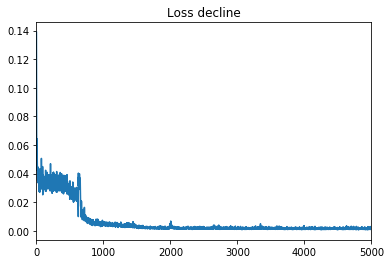

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')


INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold = (np.sort(foo)[-1]+min_a)/2
threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2


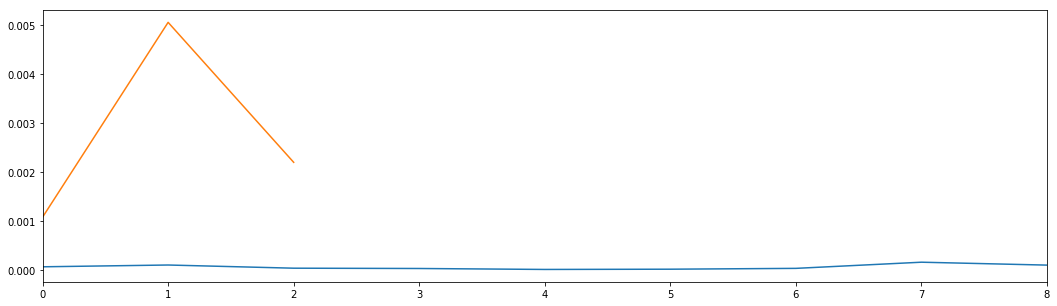

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized


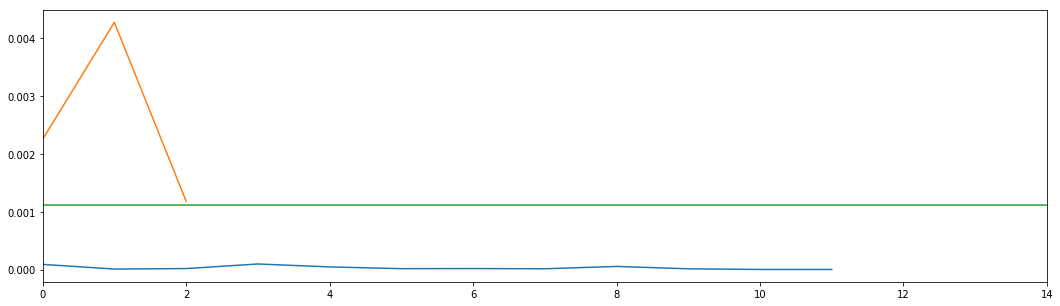

In [14]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             


    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [15]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

1.0

In [16]:
print(tp,fp,tn,fn,P,R)

3 0 12 0 1.0 1.0
